# Text Message Spam Detection


## The Business Use Case

You are the CEO of a new email service company trying to attract capital for your next growth stage. Most of the private equity firms you have spoken to want to see a user base of at least 100,000 users prior to commiting. Due to your superb marketing team, you estimate that each day you attract 1000 new users. Typically, 10% of all email messages are spam, and an average user receives 50 emails per day.

One of your data scientists says he can provide you a model with **90% accuracy** in classifying spam / ham. Another data scientist says she can build a model that is only **80% accurate** but has **100% recall**. A third data scientist says he can build a model that has **80% accuracy** with **100% precision**.

Which of the above models would you pick to model? Why?

In [34]:
import pandas as pd
data = pd.read_csv("spam-sms.csv", encoding='latin-1')
data.shape

(5572, 2)

In [40]:
Y = data["class"].values
X = data["text"].values

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       'Ok lar... Joking wif u oni...',
       "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       ..., 'Pity, * was in mood for that. So...any other suggestions?',
       "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free",
       'Rofl. Its true to its name'], dtype=object)

# Bayes Rule

$$
\begin{equation}
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
\end{equation}
$$

For our purposes, we will redefine this as

$$
\begin{equation}
P(spam|text) = \frac{P(text|spam)P(spam)}{P(text)}
\end{equation}
$$

Here,

- **prior** means before seeing any new text (evidence). Our impression of the likelihood of certain words appearing before new evidence is introduced.
- **text** is the new message (evidence) being introduced that we want to classify as either spam or ham. Let's say we have a new text message `When are you coming home? I'm hungry.`.

- $P(text)$ is the **prior likelihood** of seeing a particular text message with that exact combination of words. For instance, `P("the car is")` will be significantly higher than `P("Downstream supply chain agents")`, especially in the **context of text messages**.
- $P(spam)$ is the likelihood that any text message will be spam. This is computed in our dataset:
```python
p_spam = sum(data["class"] == "spam") / len(data)
p_ham = 1 - p_spam # since there are only two classes
```
- $P(text|spam)$ is our **likelihood**. More specifically, the likelihood of this text message given that it is a piece of spam. It is saying, *let's assume that this message is spam. Knowing that, how likely is it that we'll find this particular combination of words in the text message?*

In order to quickly get our likelihoods, we'll need to create a **likelihood table**:


In [98]:
spam_data = data[data["class"] == "spam"]
ham_data = data[data["class"] == "ham"]
print(f"The shape of the spam_data is {spam_data.shape}. The shape of the ham_data is {ham_data.shape}.")

The shape of the spam_data is (747, 2). The shape of the ham_data is (4825, 2).


In [99]:
# Create the vocabulary list
import spacy, string
nlp = spacy.load('en')

likelihood_table = pd.DataFrame(columns=["spam", "ham"], index=list(vocabulary)).fillna(0)

# populate the spam column in our likelihood table
for i, sentence in enumerate(spam_data["text"].values):
    for token in nlp(sentence):
        if token.text.lower() not in likelihood_table.index:
            likelihood_table.loc[token.text.lower(), "spam"] = 1
        else:
            likelihood_table.loc[token.text.lower(), "spam"] += 1
likelihood_table.fillna(0, inplace=True)

In [100]:
# populate the spam column in our likelihood table
for i, sentence in enumerate(ham_data["text"].values):
    for token in nlp(sentence):
        if token.text.lower() not in likelihood_table.index:
            likelihood_table.loc[token.text.lower(), "ham"] = 1
        else:
            likelihood_table.loc[token.text.lower(), "ham"] += 1
likelihood_table.fillna(0, inplace=True)

What about words like `won`?
```python
likelihood_table.loc["won"]
```
Output:
```
spam    73.0
ham      0.0
Name: won, dtype: float64
```

What is $P(w = won|c = ham)$? If even one of the words' class-conditional probabilities is 0, then the entire likelihood will be zero, since the likelihood is simply the product of all the words' individual likelihoods.

# Additive Smoothing Techniques

We can define a new likelihood for the word `won`:

$$
\begin{equation}
P_{new}(w = won | c = ham) = \frac{N_{ham, won} + \alpha}{N_{ham} + \alpha d}
\end{equation}
$$

Here, $N_{ham, won}$ is the number of times `won` appears in a text message that is classified as ham, and $N_{ham}$ is simply the total number of messages that are classified as ham.

## Simple Optimizations to Improve Naive Bayes Probabilistic Models for Text Classification

- to may be useful to simply create a simple **co-occurence matrix**, and **run a correlation analysis** on the features (words). If certain words have extremely high correlations, you may wish to take them out, or fuse them into a single entity.
- apply smoothing techniques to handle **out-of-vocabulary test words**
- **ensemble techniques like bagging / boosting** do **not** help. There isn't any "variation" in a Naive Bayes model. Given the same trained corpus $C$, and a new text message $m$, a Naive Bayes model will always output the same prediction.

# Representing Words as Probabilities

We can represent a sentence (a sequence of words) mathematically as 

$$
\begin{equation}
w = \{{w_0, w_1, w_2, \dots,w_{s-1}}\}
\end{equation}
$$

Here, **$s$** represents the total number of words in the sentence. **$w_{0}$** represents the first word in the sentence, **$w_{1}$** represents the second word in the sentence, and so on.

# Exercise:

`Older people, like everyone else, can benefit from accessing ride-sharing, but many are not comfortable with smart-phones.`

You can ignore punctuation and capitalization for now.

1. What is $s$?
2. What is $w_4$? What is $w_6$?
3. What is $V$ (this corpus' vocabulary size, assuming this is the only sentence in the corpus)? You can do this the hard way, by counting manually.

```python
sentence = "Older people, like everyone else, can benefit from accessing ride-sharing, but many are not comfortable with smart-phones"

import re # the most efficient, concise way (less readable)
vocabulary = set([re.sub(r'[^\w\s]','',word).lower() for word in sentence.split()])
print("The size of the vocabulary is {} words".format(vocabulary))
```

# Independence

In statistics, two events are independent if the outcome of one event does not affect the probability of the outcomes of another event.

![https://en.wikipedia.org/wiki/Independence_(probability_theory)](images/prob_independence.svg)

You will also often see this written as 
$$
\begin{equation}
P(A,B) = P(A) * P(B)
\end{equation}
$$

In other words, an event A is independent of event B if the **probability of event A and event B happening together** is equal to **the probability of event A multplied by the probability of event B**.

![https://en.wikipedia.org/wiki/Independence_(probability_theory)](images/conditional-probability.png)

# Bigram Model

A bigram is a group of two tokens (frequently words) that are treated as one distinct entity. For instance, the distinct bigrams in the sentence `I am home now` would be
```python
bigrams = [
    ("I", "am"),
    ("am", "home"),
    ("home", "now")
]
```


### Exercise:
Write a Python function to find all the bigrams in the sentence
`In recent years, Johnson & Johnson has been focusing more on its high-margin pharmaceutical segment via acquisitions.`

**Hints**:
- split the sentence into a list of individual words (`my_sentence.split()`)
- remove punctuation
- lowercase all the letters
- use a for loop to iterate through this list, getting the **i-th** and **i + 1-th** elements of the list

**Challenge**:
Generalize this function to work with `n-grams`.

## Language Model

Are words in a sentence conditionally independent from each other? In other words, does knowing that the first word `The` change your belief in the likelihood of the second word that follows?

Which of the following sentences is more likely?

```python
sentence_A = "Jack went to Wal-Mart."
sentence_B = "at and the be of I"
```
Notice that all the words in sentence B come from [Wikipedia most common words in the English language](https://en.wikipedia.org/wiki/Most_common_words_in_English). Yet we intuitively know that the sentence is nonsensical and is unlikely to be seen in natural language.

We can express the likelihood of a sentence $w$ as $p(w)$, and define it as
$$
\begin{equation}
p(w) = \prod_{i=0}^{s}p(w_{i+1}|w_{i})
\end{equation}
$$

If we want to generalize this to an **N-Gram** model:

$$
\begin{equation}
p(w) = \prod_{i=0}^{s}p(w_i |w_{i-n+1}, w_{i-n+2}, \dots, w_{i})
\end{equation}
$$
$$
\begin{equation}
p(w) = \prod_{i=0}^{s}p(w_i | w_{i-n}^{i})
\end{equation}
$$

Here, $w_{i-n}^{i} = w_{i-n+1}, w_{i-n+2}, \dots, w_{i}$.

## Model Evaluation: Choosing n in an n-Gram Model

- the larger the dataset, and by implication, the more rich the corpus, the larger the n we can likely try.
- in practice, $n = 2$, $n = 3$, $n = 4$ work well. A larger $n$ tends to begin to overfit (and may be computationally extremely expensive). Remember the **bias-variance** tradeoff:
![http://scott.fortmann-roe.com/docs/BiasVariance.html](images/biasvariance.png)
Here, as $n \rightarrow \infty$, model complexity increases dramatically.
- **tune $n$ based on the performance of the downstream model**: usually n-gram models are the first step in a broader sentiment analysis prediction model, or topic modelling model, recommendation system, or sequence-to-sequence translation task.

### Perplexity

Look again at the definition of likelihood for a particular sentence:

$$
\begin{equation}
L = p(w) = \prod_{i=0}^{s}p(w_i | w_{i-n}^{i})
\end{equation}
$$

Here, $w_{i-n}^{i}$ stands for $w_{i-n}, w_{i-n+1}, ..., w_{i-1}$ (if you have bi-gram (`n=2`) model, then you would have $w_{i-2}, w_{i-1}$)

Is it reasonable to compare two sentences, one with $s=4$ (sentence length of 4 words) with the one below in Sentence B?

##### Sentence A:
> *I love to eat.*

##### Sentence B:
> *My escort was an exceptionally genial sixty-seven-year-old man named Don Seely, an electrical engineer who said that he was between jobs and using the unwanted free time to volunteer his services to the Northern Kentucky Tea Party, the rally’s host organization, as a Webmaster.*

Answer: **No**. A common way of quantifying the likelihood of your n-gram models, accounting for different sizes of test corpuses, is to use **perplexity**. Remember that our likelihood of seeing a particular sentence is 

$$
\begin{equation}
P = \frac{1}{\sqrt[N]{p(w)}}
\end{equation}
$$
$N$ is the length of all the words in the corpus. We typically use perplexity, instead of simply likelihood, as the overall model evaluation metric, because in general, **in order to compare two different models**, they should be using the same test corpus / vocabulary. 

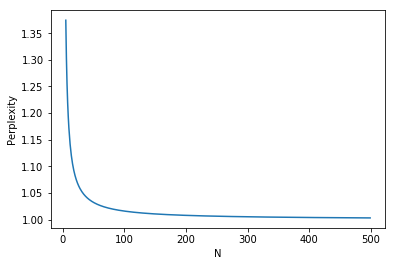

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def perplexity(likelihood, N):
    return 1 / (likelihood ** (1/N))

x = []
y = []
for i in range(5, 500):
    x.append(i)
    y.append(perplexity(likelihood=.204, N=i)) # an example likelihood of .004

plt.plot(x, y)
plt.xlabel("N")
plt.ylabel("Perplexity")
plt.show()

## Dealing with Out-of-Vocabulary Words

Let's pretend that our training corpus is

> *This is mistaken logic. It is true that a high variance and low bias model can preform well in some sense.*

Our test corpus is

> *This **is not** true.*

Assuming a bi-gram model is used, what is the **perplexity** of our model? 

We don't actually need to count each bi-gram. **The answer is infinity**. Why?
$
\begin{equation}
p(w_i = not | w_{i-1} = is) = 0
\end{equation}
$

What you can do instead:

* Look at the **frequency distribution** of words in your corpus
* Decide upon some **threshold cutoff**, where every word below that threshold frequency will be converted into an `UNKNOWN` token. Now, whenever a new word appears that is out of vocabulary, you simply convert it into `UNKNOWN` and run the tests as usual.